In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Bayes Model comparison
Model 1: Fair coin $(p = 0.5)$ <br>
Model 2: Rigged to heads $(p = 0.9)$ <br>
Model 3: Rigged to tails $(p = 0.1)$ <br>

In [2]:
#Define the models and their prior probabilities
models = ['Fair', 'Heads_Rigged', 'Tails_Rigged']
models_p = [0.5, 0.9, 0.1]

# Equal prior probability for each model
priors = np.array([1/3, 1/3, 1/3])  

In [3]:
# Let's say we observed the following sequence of coin flips: 
data = ['H', 'H', 'T', 'T', 'H', 'H', 'H', 'H', 'H', 'H']
data_binary = [1 if x == 'H' else 0 for x in data]
n_heads = data.count('H')
n_tails = len(data) - n_heads

## Bayes Updating
To calculate which model is more likely given the data, we can use the Bayes rule to update our prior to give us the posterior belive of our models. <br>
The posterior probability of a model given the data is given by:
$$ \begin{align*}
P(\mathcal{M}_i|\text{data}) &= \frac{P(\text{data}|\mathcal{M}_i)P(\mathcal{M}_i)}{\sum_{j=1}^{3} P(\text{data}|\mathcal{M}_j)P(\mathcal{M}_j)} = \frac{P(\text{data}|\mathcal{M}_i)P(\mathcal{M}_i)}{P(\text{data})} \\ \\
\text{Posterior} &= \frac{\text{Likelihood} \times \text{Prior}}{\text{Evidence}}
\end{align*} $$

## Prior
The prior probability of a model is our initial belief of the model before observing the data. <br>
In our case, we assume that all models are equally likely, so $P(\mathcal{M}_i) = \frac{1}{3}$.

## Likelihood
The likelihood function gives us the probability of observing the data given the model $\mathcal{M}_i$ is true. <br>

In [4]:
# Compute the likelihood of the data under each model
likelihoods = np.ones(3)

for obs in data_binary:
    for model_id,_ in enumerate(models):
        likelihoods[model_id] *= models_p[model_id]*obs + (1 - models_p[model_id])*(1-obs)

print(likelihoods)

[9.7656250e-04 4.3046721e-03 8.1000000e-09]


## Evidence
The evidence is the probability of observing the data regardless of the model. <br>
$$ P(\text{data}) = \sum_{j=1}^{3} P(\text{data}|\mathcal{M}_j)P(\mathcal{M}_j) $$

In [5]:
evidence = np.sum(likelihoods * priors)
print(evidence)

0.001760414233333333


## Model Comparison


In [6]:
model_posteriors = likelihoods * priors / evidence

print("Model posteriors:"+
      f"\nGiven the observations {data}" + 
      f"\nThe probabilities of the three models describing our data are:")
for m,p in zip(models, model_posteriors):
    print(f"{m:{''}{12}}: {p*100:.1f} %")

Model posteriors:
Given the observations ['H', 'H', 'T', 'T', 'H', 'H', 'H', 'H', 'H', 'H']
The probabilities of the three models describing our data are:
Fair        : 18.5 %
Heads_Rigged: 81.5 %
Tails_Rigged: 0.0 %


## Plot

In [29]:
def update_posterior(prior, obs):
    # Compute the new model posteriors given a single new observation (obs)
    likelihoods = np.ones(3)
    for model_id,_ in enumerate(models):
        likelihoods[model_id] = models_p[model_id]*obs + (1 - models_p[model_id])*(1-obs)

    evidence = np.sum(likelihoods * prior)
    model_posteriors = likelihoods * prior / evidence
    return model_posteriors

In [30]:
# Initial model prior probabilities
priors = np.array([1/3, 1/3, 1/3])
posterior_probs = {model: [p] for p, model in zip(priors, models)}

for i, toss in enumerate(data_binary):
    priors = update_posterior(priors, toss)

    # Store the updated posterior probabilities
    for model, posterior in zip(models, priors):
        posterior_probs[model].append(posterior)

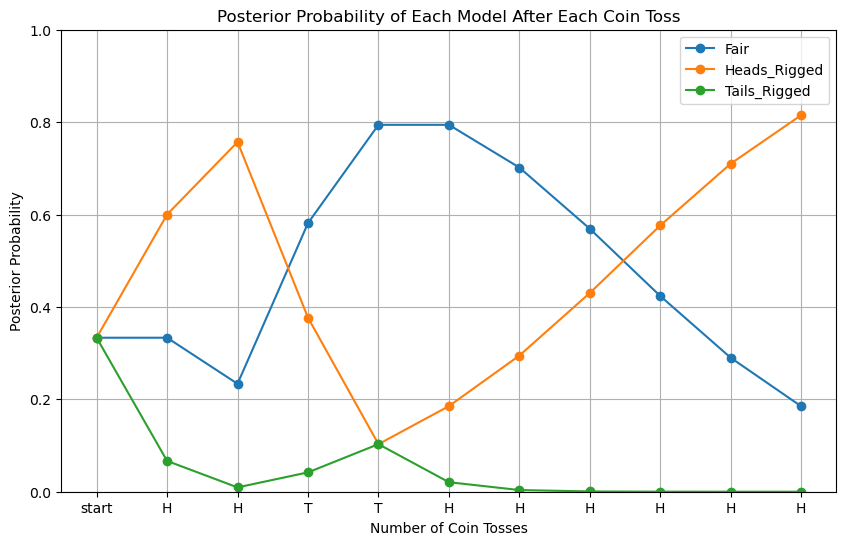

In [31]:
# Plotting the results
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(range(0, len(data) + 1), posterior_probs[model], marker='o', label=model)

plt.xlabel('Number of Coin Tosses')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probability of Each Model After Each Coin Toss')
plt.legend()
plt.xticks(range(0, len(data) + 1), ["start"]+data)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Model Comparison AIC
In the case where we just have access to a simulator, that can just be used to generate data, like in a SBI setting, we can use the Akaike Information Criterion (AIC) to compare models. <br>
The AIC is a measure of the relative quality of a statistical model for a given set of data. It is based on the likelihood function and penalizes for the number of parameters in the model. <br>
The AIC is given by:
$$ \text{AIC} = -2 \log(P(\text{data}|\mathcal{M}_i)) + 2k $$
where $k$ is the number of parameters in the model. <br>

However, like shown in the ReadMe, when we have access to the likelihood function, or can approximate it, we can simlpy perform the softmax on the log-likelihoods of the models. <br>
$$
P(\mathcal{M}_i|\text{data}) = \text{softmax} \big( \ln \mathcal{\hat L}_i \big)
$$

In [10]:
aic = np.log(likelihoods)
print("AIC values:")
for m,a in zip(models, aic):
    print(f"{m:{''}{12}}: {a:.1f}")

print("\nProbabilities of the models given the AIC values:")
# Using softmax to convert AIC values to probabilities
aic_pobs = scipy.special.softmax(aic)
for m,p in zip(models, aic_pobs):
    print(f"{m:{''}{12}}: {p*100:.1f} %")

AIC values:
Fair        : -6.9
Heads_Rigged: -5.4
Tails_Rigged: -18.6

Probabilities of the models given the AIC values:
Fair        : 18.5 %
Heads_Rigged: 81.5 %
Tails_Rigged: 0.0 %


In [26]:
def model_posterior_aic(obs):
    # Compute the new model posteriors given a single new observation (obs)
    likelihoods = np.ones(3)
    obs = np.array(obs)
    for model_id,_ in enumerate(models):
        ln_L = models_p[model_id]*obs + (1 - models_p[model_id])*(1-obs)
        likelihoods[model_id] = np.sum(np.log(ln_L))

    model_posteriors = scipy.special.softmax(likelihoods)
    return model_posteriors

In [27]:
# Initial model prior probabilities
posterior_probs_aic = {model: [] for model in models}

for i, toss in enumerate(data_binary):
    priors = model_posterior_aic(data_binary[:i+1])

    # Store the updated posterior probabilities
    for model, posterior in zip(models, priors):
        posterior_probs_aic[model].append(posterior)

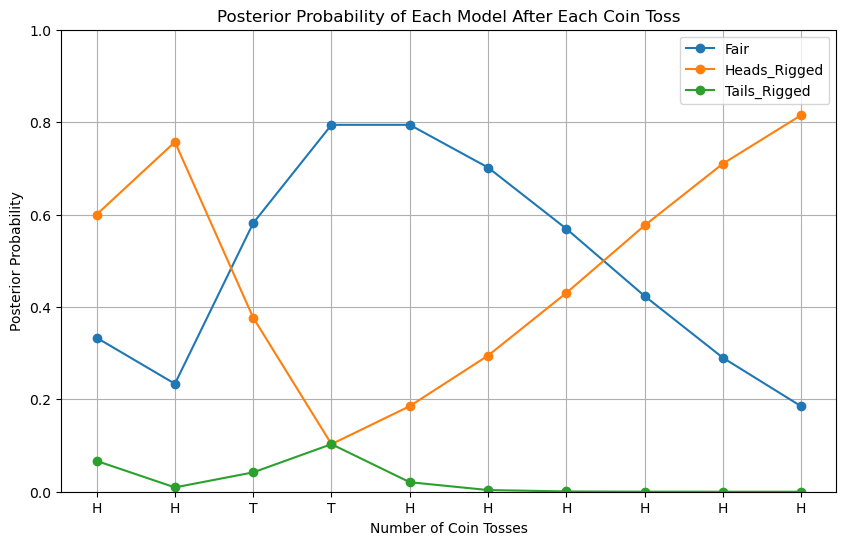

In [28]:
# Plotting the results
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(range(0, len(data)), posterior_probs_aic[model], marker='o', label=model)

plt.xlabel('Number of Coin Tosses')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probability of Each Model After Each Coin Toss')
plt.legend()
plt.xticks(range(0, len(data)), data)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Because the AIC is a relative measure of the observed data, we are just comparing the likelihoods of the models and not updating the prior like in the Bayesian setting. <br>
Therefore we just start from the first observation. <br>

But we can clearly see, that the results obtaiened from the AIC and the Bayes model comparison are very similar (basically indistinguishable). <br>
So in order to compare the models, we can just use the AIC, which is limited by the accuracy of the likelihood astimation.